<a href="https://colab.research.google.com/github/ryu-i-engineer/ImageAnnotationChallenge/blob/main/notebooks/ImageAnnotationChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ImageAnnotationChallenge

## Overview : 概要

### Project target : プロジェクト目標

- 普通のECサイトにおける検索機能について､改善方法を検討する
- 画像認識によるタグ付けの開発を優先する
- メンバーも実際のプロジェクト経験をもらいつつ､デモプロジェクトの開発と記事を作成できるまで頑張る

In English:
- Consider the ways how to improve search function on e-commerce site.
- Prioritize the development of tagging by image recognition.
- The members will do our best until creating an article and developing demo project, gaining project experience.


### Study scope : 学習範囲

* Note記事を書く
* 画像認識によるタグ付けを優先して開発する
* 日本語･英語両方タグ付けできるようにする

In English:

* Write a note article
* Develop tagging system by image recognition in priority
* The system becomes able to tag  in Japanese and English


### Repository

* [TOP](https://github.com/ryu-i-engineer/ImageAnnotationChallenge)
* [Projects](https://github.com/ryu-i-engineer/ImageAnnotationChallenge/projects/2)

## Reference

- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
- https://www.tensorflow.org/tutorials/images/segmentation

### About Transfer learning

#### Domain problem

- [転移学習：機械学習の次のフロンティアへの招待](https://qiita.com/icoxfog417/items/48cbf087dd22f1f8c6f4#%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92%E3%81%AE%E5%8F%96%E3%82%8A%E7%B5%84%E3%82%80%E5%95%8F%E9%A1%8C)

## Dataset

### Using web scraping

From here.
- https://jp.misumi-ec.com/vona2/mech_screw/M3303000000/?rid=c21_top_4_M3303000000

In [ ]:
import os
import seaborn as sns
import pandas as pd

misumi_dataset_path = "./inputs/misumi_dataset_cleansing"

label_names = []
label_file_counts = []

for dir_name in os.listdir(misumi_dataset_path):
    label_names.append(dir_name)
    label_file_counts.append(len([filename for filename in os.listdir(os.path.join(misumi_dataset_path, dir_name)) if os.path.isfile(os.path.join(misumi_dataset_path, dir_name, filename))]))
    

In [ ]:
d = {'Labels' : label_names, 'File counts': label_file_counts}
misumi_df = pd.DataFrame(d)
misumi_df.describe()

,File counts
count,134.000000
mean,87.089552
std,170.999559
min,2.000000
25%,17.000000
50%,40.000000
75%,86.750000
max,1491.000000


### Dummy data

- 3D
- CAD
- Items should not be there.
- Utilities something like "Accessories" and "Components"

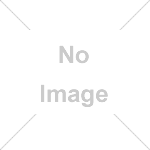
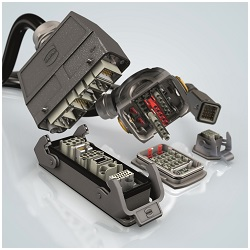
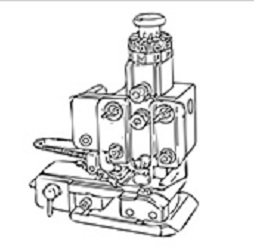
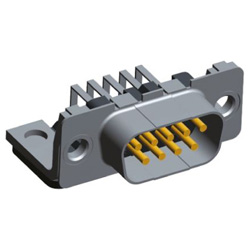

### Define lables and binarize

#### CSV format

```csv
"directory","filename","tag1","tag2","tag3","tag4","tag5","tag6","tag7","tag8","tag9","tag10"
"nuts","test.jpg","nuts","metal","hex",
"bolts","test2.jpg","nuts","non-metal","screws","flat"
```

#### Code

In [1]:
import pandas as pd
df = pd.read_csv("./inputs/fasteners/fasteners_label.csv")
df.dropna(axis=1, how="all")

,directory,filename,tag1,tag2,tag3,tag4,tag5,tag6,tag7,tag8,tag9,tag10,tag11,tag12,tag13
0,screw,000000.jpg,Silver,Internal Head,Square Head,Bugle Head,Stainless Steel,Deck Screw,Coarse,NaN,NaN,NaN,NaN,NaN,NaN
1,screw,000001.jpg,Silver,Internal Head,Square Head,Bugle Head,Stainless Steel,Deck Screw,Coarse,NaN,NaN,NaN,NaN,NaN,NaN
2,screw,000002.jpg,Silver,Internal Head,Square Head,Bugle Head,Stainless Steel,Deck Screw,Coarse,NaN,NaN,NaN,NaN,NaN,NaN
3,screw,000003.jpg,Blue,Phillips Head,Flat Head,Carbon Steel,Masonry Anchor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,screw,000004.jpg,Blue,Phillips Head,Flat Head,Carbon Steel,Masonry Anchor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,screw,003987.jpg,Burgundy,External Head,Hex Head,Hex Head,Washer Head,Steel,Roofing Screw,Hi-Lo,NaN,NaN,NaN,NaN,NaN
3794,screw,003988.jpg,Burgundy,External Head,Hex Head,Hex Head,Washer Head,Steel,Roofing Screw,Hi-Lo,NaN,NaN,NaN,NaN,NaN
3795,screw,003989.jpg,Bronze,External Head,Hex Head,Hex Head,Washer Head,Steel,Roofing Screw,Hi-Lo,NaN,NaN,NaN,NaN,NaN
3796,screw,003990.jpg,Bronze,External Head,Hex Head,Hex Head,Washer Head,Steel,Roofing Screw,Hi-Lo,NaN,NaN,NaN,NaN,NaN


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

df = df.dropna(axis=1, how='all') # save memory and process usage
df = df.fillna('None') # to avoid error

result = mlb.fit_transform( df.drop(columns=['directory', 'filename']).values) # drop not tagging cols

bin_df = pd.DataFrame(result, columns=mlb.classes_).drop('None', axis=1) # drop non-useless col.
bin_df = df.join(bin_df).drop(["tag1", "tag2", "tag3", "tag4", "tag5", "tag6", "tag7", "tag8","tag9", "tag10", "tag11","tag12", "tag13"], axis=1)
bin_df.head()

,directory,filename,6 Lobe Head,Allen,Aluminum,Binding,Black,Blue,Bolt,Brass,...,Timber Bolt,Torx 6 Lobe Screw,Trim,Truss Head,"Truss Head""",Washer Head,White,Wood Screw,Yellow,Zinc Plated Steel
0,screw,000000.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,screw,000001.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,screw,000002.jpg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,screw,000003.jpg,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,screw,000004.jpg,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# get tag list
bin_df.drop(['directory', 'filename'], axis=1).columns.to_list()

['6 Lobe Head',
 'Allen',
 'Aluminum',
 'Binding',
 'Black',
 'Blue',
 'Bolt',
 'Brass',
 'Bronze',
 'Brown',
 'Bugle Head',
 'Burgundy',
 'Button Head',
 'Cap Screw',
 'Carbon Steel',
 'Carriage Bolt',
 'Charcoal',
 'Coarse',
 'Deck Screw',
 'Dome Head',
 'Dowel Screw',
 'Drywall Screw',
 'External Head',
 'Fillister',
 'Fine',
 'Flange Head',
 'Flat Head',
 'Framing Drywall Screw',
 'Framing Self Drilling Drywall Screw',
 'Fully Threaded Head',
 'Gray',
 'Green',
 'Hanger Bolt',
 'Hex Head',
 'Hi-Lo',
 'Indented Truss',
 'Internal Head',
 'Ivory',
 'Knurled Head',
 'Lag Screw',
 'Laminating Drywall Screw',
 'Lath Screw',
 'Machine Screw',
 'Machine Screw Anchor Set Tool',
 'Masonry Anchor',
 'Modified Truss',
 'No Head',
 'Non-Serrated Flange Bolt',
 'One Way Head',
 'Oval Head',
 'Oversize Truss',
 'Pan Head',
 'Pancake Head',
 'Phillips Head',
 'Plow Bolt',
 'Red',
 'Roofing Screw',
 'Round Head',
 'SEMS Machine Screw',
 'Sammy Rod Hanger Anchors',
 'Self Drilling Drywall Screw',
 

In [4]:
N = len(df)

just_num = max(len(l) for l in bin_df.drop(['directory', 'filename'], axis=1).columns)+1

for k, label in enumerate(bin_df.drop(['directory', 'filename'], axis=1).columns):
    pos = sum(bin_df[label] == 1)
    print(f"{label.ljust(just_num)}\tPos samples: {pos:<5}\tNeg samples: {N-pos:<5} \t Pos of total: {100 * pos / N:.2f}%")

6 Lobe Head                         	Pos samples: 12   	Neg samples: 3786  	 Pos of total: 0.32%
Allen                               	Pos samples: 1062 	Neg samples: 2736  	 Pos of total: 27.96%
Aluminum                            	Pos samples: 15   	Neg samples: 3783  	 Pos of total: 0.39%
Binding                             	Pos samples: 3    	Neg samples: 3795  	 Pos of total: 0.08%
Black                               	Pos samples: 294  	Neg samples: 3504  	 Pos of total: 7.74%
Blue                                	Pos samples: 14   	Neg samples: 3784  	 Pos of total: 0.37%
Bolt                                	Pos samples: 3    	Neg samples: 3795  	 Pos of total: 0.08%
Brass                               	Pos samples: 147  	Neg samples: 3651  	 Pos of total: 3.87%
Bronze                              	Pos samples: 93   	Neg samples: 3705  	 Pos of total: 2.45%
Brown                               	Pos samples: 9    	Neg samples: 3789  	 Pos of total: 0.24%
Bugle Head                   

#### Tag list

See also,
- [Fasterner(wiki)](https://en.wikipedia.org/wiki/Fastener)
- [Nuts(wiki)](https://en.wikipedia.org/wiki/Nut_(hardware))
- [Wahser(wiki)](https://en.wikipedia.org/wiki/Washer_(hardware))
- [Electrical cable(wiki)](https://en.wikipedia.org/wiki/Electrical_cable)

##### Components


- accessories
- caps
- cables
- connector
- conduits
- bolts
- ducts
- fully-threaded
- image_seonsor
- io_board
- mount
- nuts
- pins
- rings
- screws
- tape
- tie
- tools
- washer
- wire

##### Materials


- metal
- nylon
- plastic
- celamic

##### Shapes

- ac_servo
- av_antenna
- audio_video
- branching
- clinching
- clip
- crimp
- cylindrical
- display
- domed
- eye_screws
- fiber_optic
- flanged
- flat
- gauge
- hex
- high
- inserts
- knurled
- lan
- lock
- machine_keys
- micro
- precise
- printer
- ps2
- rectangular
- rivet
- rc232
- scsi
- slot
- spacer
- thumb_ornamental
- usb
- wing
- weld

## Codes

### Using TF Hub for Transfer learning

#### Prepare

In [3]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12428958699026417367
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4853137408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15299635210368823934
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


#### Visualization of model training history

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Export model

In [ ]:
from datetime import date

export_path = f"./models/{date.today().isoformat()}_{str(int(time.time()))}"
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: ./models/2021-10-26_1635176309\assets


'./models/2021-10-26_1635176309'

In [ ]:
# import os
# # os.listdir("./models/")
# print(len(next(os.walk('./models/'))[1]))

2


In [ ]:
# reloaded = tf.keras.models.load_model(export_path)

In [ ]:
# result_batch = model.predict(image_batch)
# reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
# abs(reloaded_result_batch - result_batch).max()

## Load dataset

In [4]:
LABELS = bin_df.columns[2:].to_list()
LABELS[:5]

['6 Lobe Head', 'Allen', 'Aluminum', 'Binding', 'Black']

In [5]:
import glob, os
data_dir = "./inputs/fasteners/screw"
filenames = glob.glob(os.path.join(data_dir, "*.jpg"))

In [6]:
ds_size = len(filenames)
print("Number of images in folders: ", ds_size)

number_of_selected_samples = 3798
filelist_ds = tf.data.Dataset.from_tensor_slices(filenames[:number_of_selected_samples])

ds_size=filelist_ds.cardinality().numpy()
print("Number of selected samples for dataset: ", ds_size)

Number of images in folders:  3798
Number of selected samples for dataset:  3798


In [7]:
filenames[:5]

['./inputs/fasteners/screw\\000000.jpg',
 './inputs/fasteners/screw\\000001.jpg',
 './inputs/fasteners/screw\\000002.jpg',
 './inputs/fasteners/screw\\000003.jpg',
 './inputs/fasteners/screw\\000004.jpg']

In [8]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  file_name= parts[-1]
  return tf.squeeze(bin_df[bin_df['filename']==file_name][LABELS])

In [79]:
IMG_WIDTH, IMG_HEIGHT = 64 , 64
def decode_img(img):
  #color images
  img = tf.image.decode_jpeg(img, channels=3) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32)
  #resize
  img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

  img = tf.image.random_flip_left_right(img, seed=42)
  img = tf.image.random_flip_up_down(img, seed=42)
  img = tf.keras.preprocessing.image.random_zoom(img, (0.5, 1.5))
#   img = tf.keras.preprocessing.image.random_rotation(img, 0.2)
#   img = tf.image.random_contrast(img, 0.8, 1.2, seed=42)
  return img

In [10]:
def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  label = tf.cast(label, tf.int64)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [59]:
train_ratio = 0.80
ds_train=filelist_ds.take(ds_size*train_ratio)
ds_test=filelist_ds.skip(ds_size*train_ratio)

In [12]:
BATCH_SIZE = 64

In [60]:
ds_train=ds_train.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [61]:
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [27]:
def covert_onehot_string_labels(label_string,label_onehot):
  labels=[]
  for i, label in  enumerate(label_string):
     if label_onehot[i]:
       labels.append(label)
  if len(labels)==0:
    labels.append("NONE")
  return labels

25 samples from the dataset


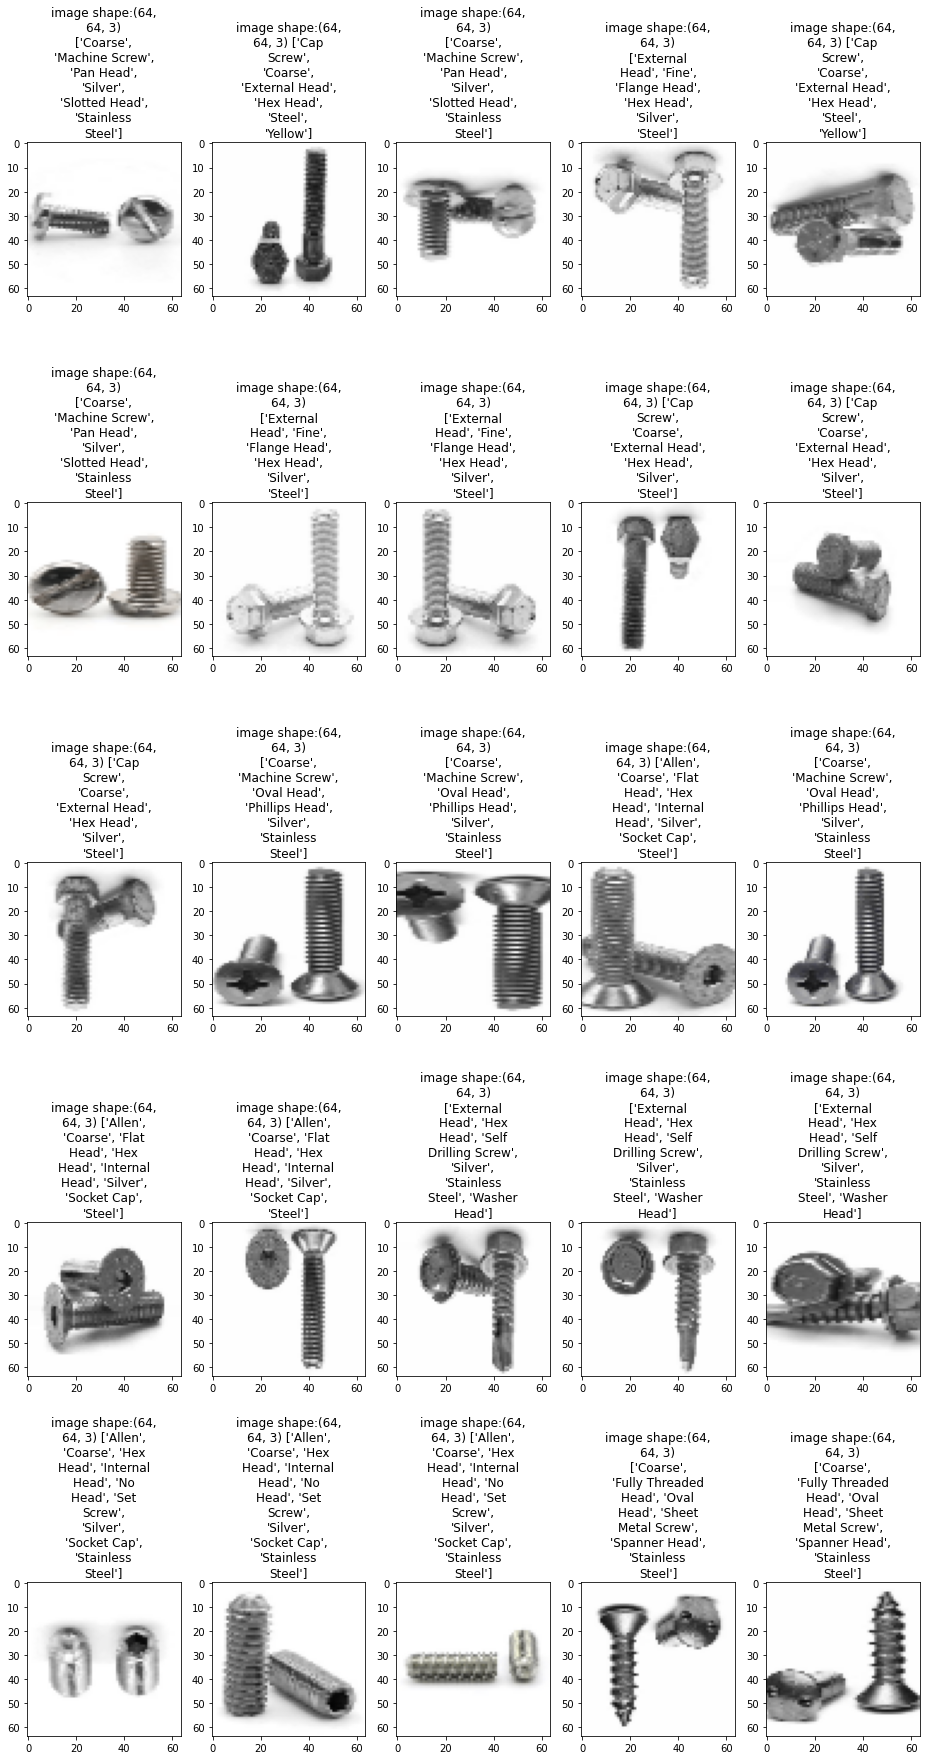

In [80]:
from textwrap import wrap

def show_samples(dataset):
  fig=plt.figure(figsize=(16, 16))
  fig.set_figheight(32)
  columns = 5
  rows = 5
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow((np.squeeze(a) * 255).astype('uint8'))
    plt.title('\n'.join(wrap("image shape:"+ str(a.shape)+" "+ 
              str(covert_onehot_string_labels(LABELS,b.numpy())), 16)))
    i=i+1
  plt.show()
show_samples(ds_test)

In [81]:
#buffer_size = ds_train_resize_scale.cardinality().numpy()/10
#ds_resize_scale_batched=ds_raw.repeat(3).shuffle(buffer_size=buffer_size).batch(64, )

ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())

Number of batches in train:  48
Number of batches in test:  12


## Create model

In [21]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
effienct_v2 = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


feature_extractor_model = effienct_v2

In [82]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    trainable=False
)

In [84]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# aug = ImageDataGenerator(
#     rotation_range=25,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [83]:
num_classes = len(LABELS)

base_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    feature_extractor_layer,
    # tf.keras.layers.Dense(num_classes, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='sigmoid'),
])
base_model.build((None,)+(IMG_WIDTH, IMG_HEIGHT, 3))
model = base_model

### Create custom loss function

In [85]:
weight_balanced = []
N = len(bin_df)

for k, label in enumerate(bin_df.drop(['directory', 'filename'], axis=1).columns):
    weight_balanced.append((bin_df[label] == 1).sum())

max_count = max(weight_balanced)

for i in range(len(weight_balanced)):
    weight_balanced[i] = max_count / weight_balanced[i]

weight_balanced = tf.constant(weight_balanced, dtype=tf.float32)
weight_balanced

<tf.Tensor: shape=(91,), dtype=float32, numpy=
array([2.50083328e+02, 2.82580042e+00, 2.00066666e+02, 1.00033331e+03,
       1.02074833e+01, 2.14357147e+02, 1.00033331e+03, 2.04149666e+01,
       3.22688179e+01, 3.33444458e+02, 4.54696960e+01, 2.50083328e+02,
       1.07562723e+01, 7.63613224e+00, 2.09860134e+01, 3.12604160e+01,
       2.50083328e+02, 1.00000000e+00, 6.25208321e+01, 2.77870369e+01,
       1.66722229e+02, 2.50083328e+02, 3.23035526e+00, 1.00033331e+03,
       5.26491213e+00, 3.33444443e+01, 4.00667572e+00, 1.00033331e+03,
       1.00033331e+03, 1.25041664e+02, 4.16805573e+01, 1.25041664e+02,
       1.00033333e+02, 1.49377799e+00, 2.63245621e+01, 8.33611145e+01,
       2.38743043e+00, 2.50083328e+02, 1.66722229e+02, 4.16805573e+01,
       1.00033331e+03, 1.00033331e+03, 3.84250951e+00, 1.00033331e+03,
       2.50083328e+02, 3.33444458e+02, 9.80718994e+00, 1.00033331e+03,
       1.42904755e+02, 1.66722221e+01, 2.00066666e+02, 6.26513577e+00,
       2.50083328e+02, 4.26884

In [86]:
# create custom loss function
def custom_weighted_bce(y_true, y_pred):
    loss = tf.nn.weighted_cross_entropy_with_logits(tf.cast(y_true, tf.float32), y_pred, weight_balanced)
    return tf.reduce_mean(loss, axis=1)

In [87]:
model.compile(
  optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0005),
  loss=custom_weighted_bce,
  metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              4049564   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 91)                116571    
Total params: 4,166,135
Trainable params: 116,571
Non-trainable params: 4,049,564
_________________________________________________________________


## Train model

In [88]:
NUM_EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.001, patience=5
)

history = model.fit(ds_train_batched,
                    validation_data=ds_test_batched,
                    epochs=NUM_EPOCHS,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/100
48/48 [==============================] - 1630s 34s/step - loss: 1.2296 - binary_accuracy: 0.8527 - val_loss: 1.2150 - val_binary_accuracy: 0.9310
Epoch 2/100
48/48 [==============================] - 2s 44ms/step - loss: 1.1735 - binary_accuracy: 0.9400 - val_loss: 1.1974 - val_binary_accuracy: 0.9374
Epoch 3/100
48/48 [==============================] - 2s 44ms/step - loss: 1.1495 - binary_accuracy: 0.9453 - val_loss: 1.1860 - val_binary_accuracy: 0.9394
Epoch 4/100
48/48 [==============================] - 2s 46ms/step - loss: 1.1282 - binary_accuracy: 0.9468 - val_loss: 1.1768 - val_binary_accuracy: 0.9377
Epoch 5/100
48/48 [==============================] - 2s 44ms/step - loss: 1.1092 - binary_accuracy: 0.9462 - val_loss: 1.1671 - val_binary_accuracy: 0.9347
Epoch 6/100
48/48 [==============================] - 2s 45ms/step - loss: 1.0934 - binary_accuracy: 0.9448 - val_loss: 1.1580 - val_binary_accuracy: 0.9321
Epoch 7/100
48/48 [==============================] - 2s 44ms/s

## Evaluate

In [89]:
ds= ds_test_batched
print("Test Accuracy: ", model.evaluate(ds)[1])

12/12 [==============================] - 0s 34ms/step - loss: 1.0654 - binary_accuracy: 0.9493
Test Accuracy:  0.9493202567100525


In [90]:
ds=ds_test
predictions= model.predict(ds.batch(batch_size=50).take(1))
# print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(50)):
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted    : " , str(covert_onehot_string_labels(LABELS, pred)))
  print("Actual Label: ", str(covert_onehot_string_labels(LABELS,b.numpy())))
  print("")
  y.append(b.numpy())

10 Sample predictions:
predicted    :  ['Cap Screw', 'Coarse', 'External Head', 'Fine', 'Hex Head', 'Steel', 'Yellow']
Actual Label:  ['Cap Screw', 'Coarse', 'External Head', 'Hex Head', 'Steel', 'Yellow']

predicted    :  ['Black', 'Cap Screw', 'Coarse', 'External Head', 'Steel', 'Yellow']
Actual Label:  ['External Head', 'Fine', 'Flange Head', 'Hex Head', 'Silver', 'Steel']

predicted    :  ['Coarse', 'Machine Screw', 'Round Head', 'Silver', 'Slotted Head', 'Stainless Steel']
Actual Label:  ['External Head', 'Fine', 'Flange Head', 'Hex Head', 'Silver', 'Steel']

predicted    :  ['Coarse', 'Hex Head', 'Machine Screw', 'Silver', 'Stainless Steel']
Actual Label:  ['Coarse', 'Machine Screw', 'Pan Head', 'Silver', 'Slotted Head', 'Stainless Steel']

predicted    :  ['Allen', 'Coarse', 'Flat Head', 'Internal Head', 'Machine Screw', 'Pan Head', 'Silver', 'Socket Cap', 'Stainless Steel', 'Truss Head']
Actual Label:  ['Cap Screw', 'Coarse', 'External Head', 'Hex Head', 'Steel', 'Yellow']

pre

25 samples from the dataset


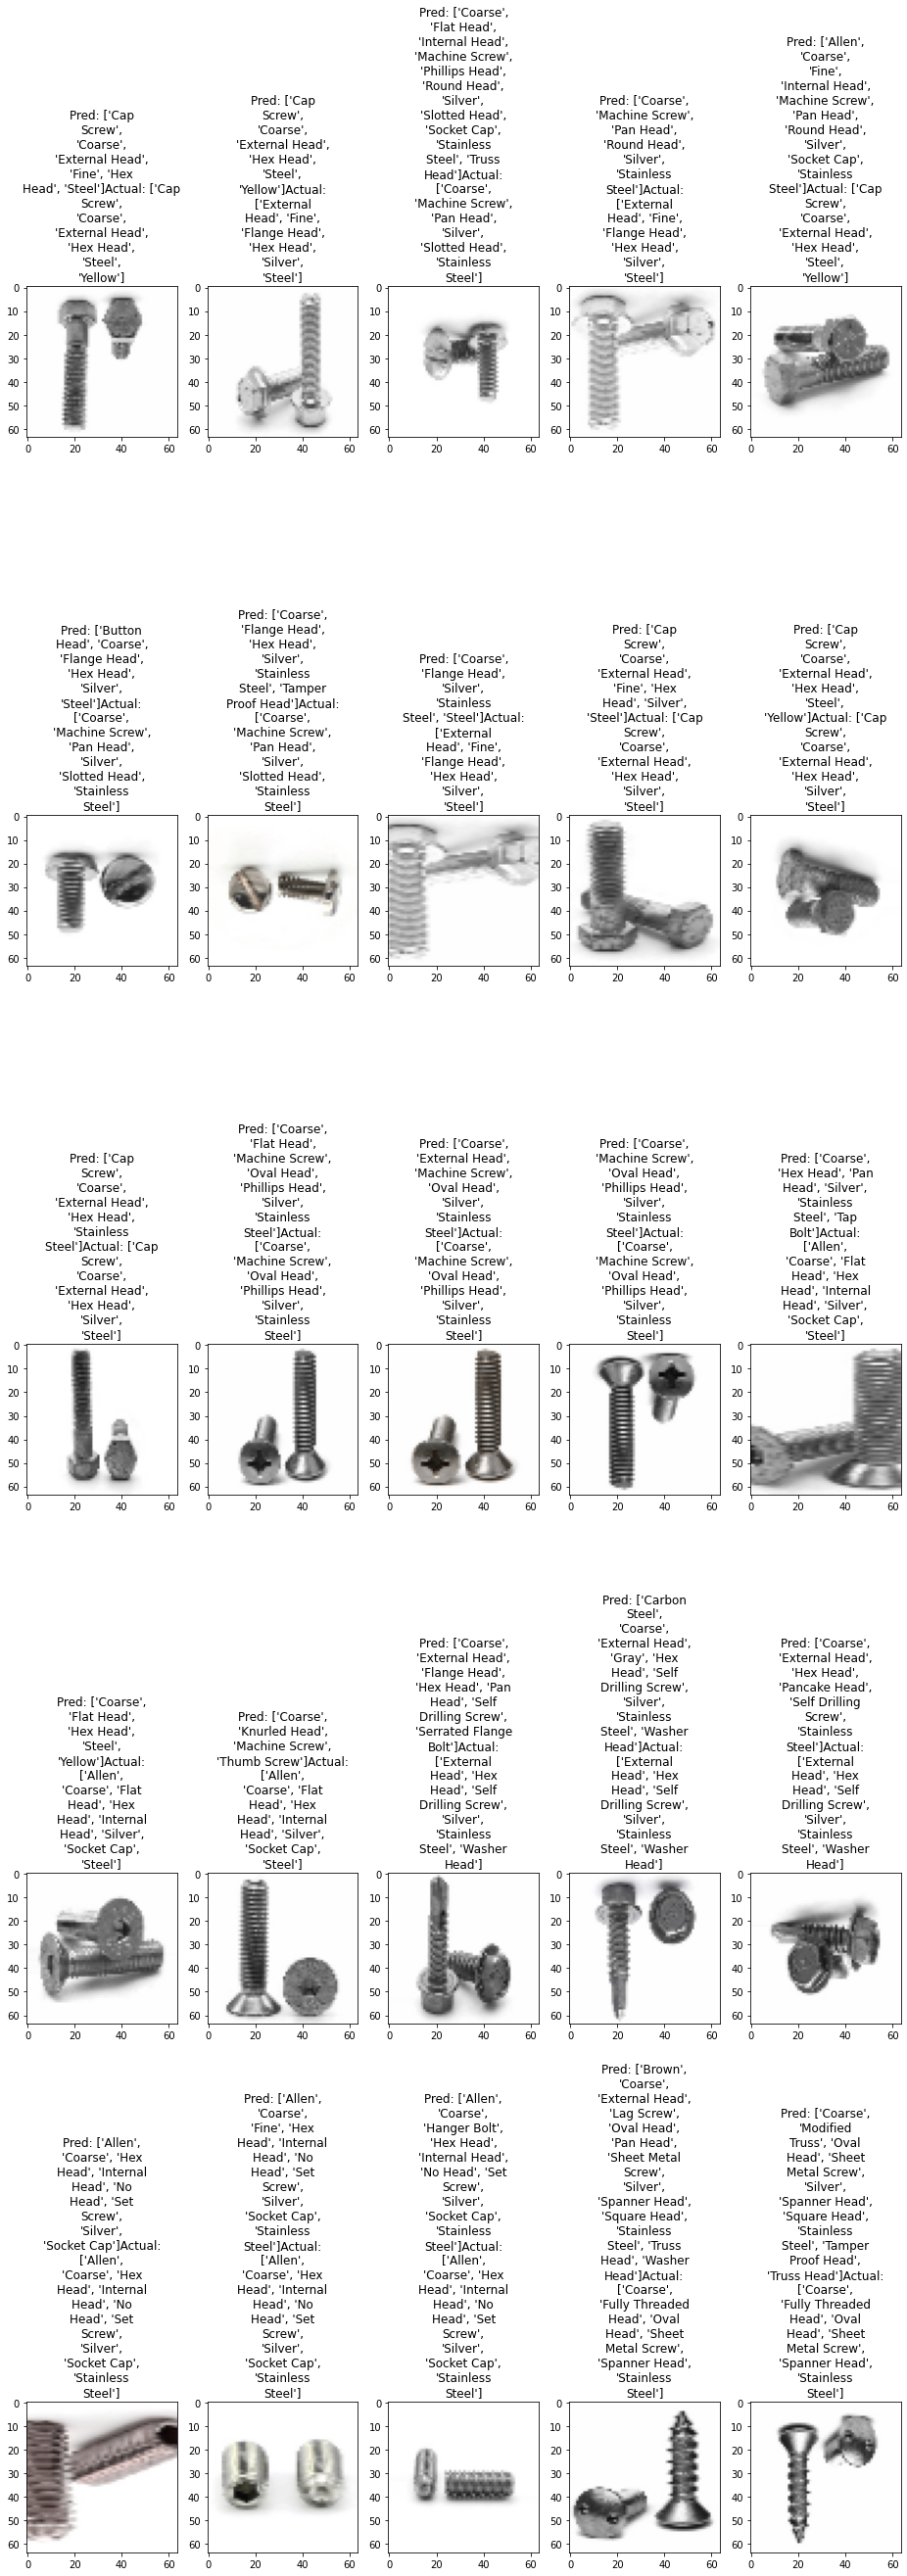

In [91]:
from textwrap import wrap

def show_samples(dataset):
    fig=plt.figure(figsize=(16, 16))
    fig.set_figheight(48)
    columns = 5
    rows = 5
    print(columns*rows,"samples from the dataset")
    predictions= model.predict(dataset.batch(batch_size=columns*rows).take(1))
    i=1
    for (pred, (a,b)) in zip(predictions, dataset.take(columns*rows)):
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.squeeze(a))
        pred[pred>0.5]=1
        pred[pred<=0.5]=0
        plt.title('\n'.join(wrap("Pred: "+ str(covert_onehot_string_labels(LABELS, pred)), 16)) + '\n'.join(wrap("Actual: "+str(covert_onehot_string_labels(LABELS, b.numpy())), 16)))
        i=i+1
    plt.show()


show_samples(ds_test)